# 1 Business Problem

- Which product categories has lower reviews / maybe inferior products? (ie. electronics, iPad)
- Which product have higher reviews / maybe superior products?
    
Business solutions:
- **Which products should be kept, dropped from Amazon's product roster (which ones are junk?)**
- **Also: can we associate positive and negative words/sentiments for each product in Amazon's Catalog**
- By using Sentiment analysis, can we predict scores for reviews based on certain words

This dataset is based on Amazon branded/Amazon manufactured products only, and Customer satisfaction with Amazon products seem to be the main focus here.

Potential suggestion for product reviews:
<br>Product X is highly rated on the market, it seems most people like its lightweight sleek design and fast speeds. Most products that were associated with negative reviews seemed to indicate that they were too heavy and they couldn't fit them in the bags. We suggest that next gen models for e-readers are lightweight and portable, based on this data we've looked at.

Assumptions:
- We're assuming that sample size of 30K examples are sufficient to represent the entire population of sales/reviews
- We're assuming that the information we find in the text reviews of each product will be rich enough to train a sentiment analysis classifier with accuracy (hopefully) > 70%

# 2 Quick Look at the Raw Data

In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import math
import warnings
warnings.filterwarnings('ignore') 
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore",category=UserWarning)
sns.set_style("whitegrid")
%matplotlib inline 
np.random.seed(7)

csv = "/content/drive/MyDrive/colab/1429_1.csv"
df = pd.read_csv(csv)
df.head(2)


,id,name,asins,brand,categories,keys,manufacturer,reviews.date,reviews.dateAdded,reviews.dateSeen,...,reviews.doRecommend,reviews.id,reviews.numHelpful,reviews.rating,reviews.sourceURLs,reviews.text,reviews.title,reviews.userCity,reviews.userProvince,reviews.username
0,AVqkIhwDv8e3D1O-lebb,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",B01AHB9CN2,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...","841667104676,amazon/53004484,amazon/b01ahb9cn2...",Amazon,2017-01-13T00:00:00.000Z,2017-07-03T23:33:15Z,"2017-06-07T09:04:00.000Z,2017-04-30T00:45:00.000Z",...,True,NaN,0.0,5.0,http://reviews.bestbuy.com/3545/5620406/review...,This product so far has not disappointed. My c...,Kindle,NaN,NaN,Adapter
1,AVqkIhwDv8e3D1O-lebb,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",B01AHB9CN2,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...","841667104676,amazon/53004484,amazon/b01ahb9cn2...",Amazon,2017-01-13T00:00:00.000Z,2017-07-03T23:33:15Z,"2017-06-07T09:04:00.000Z,2017-04-30T00:45:00.000Z",...,True,NaN,0.0,5.0,http://reviews.bestbuy.com/3545/5620406/review...,great for beginner or experienced person. Boug...,very fast,NaN,NaN,truman


In [27]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


- We can potentially refine sentiment analysis with the reviews.text column, with the actual rating of reviews.doRecommend column (boolean)
- We can also label each review based on each sentiment
    - title can contain positive/negative information about review

In [28]:
data = df.copy()
data.describe()

,reviews.id,reviews.numHelpful,reviews.rating,reviews.userCity,reviews.userProvince
count,1.0,34131.000000,34627.000000,0.0,0.0
mean,111372787.0,0.630248,4.584573,NaN,NaN
std,NaN,13.215775,0.735653,NaN,NaN
min,111372787.0,0.000000,1.000000,NaN,NaN
25%,111372787.0,0.000000,4.000000,NaN,NaN
50%,111372787.0,0.000000,5.000000,NaN,NaN
75%,111372787.0,0.000000,5.000000,NaN,NaN
max,111372787.0,814.000000,5.000000,NaN,NaN


Based on the descriptive statistics above, we see the following:
- Average review score of 4.58, with low standard deviation
    - Most review are positive from 2nd quartile onwards
- The average for number of reviews helpful (reviews.numHelpful) is 0.6 but high standard deviation
    - The data are pretty spread out around the mean, and since can't have negative people finding something helpful, then this is only on the right tail side
    - The range of most reviews will be between 0-13 people finding helpful (reviews.numHelpful)
- The most helpful review was helpful to 814 people
    - This could be a detailed, rich review that will be worth looking at

In [29]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34660 entries, 0 to 34659
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    34660 non-null  object 
 1   name                  27900 non-null  object 
 2   asins                 34658 non-null  object 
 3   brand                 34660 non-null  object 
 4   categories            34660 non-null  object 
 5   keys                  34660 non-null  object 
 6   manufacturer          34660 non-null  object 
 7   reviews.date          34621 non-null  object 
 8   reviews.dateAdded     24039 non-null  object 
 9   reviews.dateSeen      34660 non-null  object 
 10  reviews.didPurchase   1 non-null      object 
 11  reviews.doRecommend   34066 non-null  object 
 12  reviews.id            1 non-null      float64
 13  reviews.numHelpful    34131 non-null  float64
 14  reviews.rating        34627 non-null  float64
 15  reviews.sourceURLs 

Based on the information above:
- Drop reviews.userCity, reviews.userProvince, reviews.id, and reviews.didPurchase since these values are floats (for exploratory analysis only)
- Not every category have maximum number of values in comparison to total number of values
- reviews.text category has minimum missing data (34659/34660) -> Good news!
- We need to clean up the name column by referencing asins (unique products) since we have 7000 missing values

In [30]:
data["asins"].unique()

array(['B01AHB9CN2', 'B00VINDBJK', 'B005PB2T0S', 'B002Y27P3M',
       'B01AHB9CYG', 'B01AHB9C1E', 'B01J2G4VBG', 'B00ZV9PXP2',
       'B0083Q04TA', 'B018Y229OU', 'B00REQKWGA', 'B00IOYAM4I',
       'B018T075DC', nan, 'B00DU15MU4', 'B018Y225IA', 'B005PB2T2Q',
       'B018Y23MNM', 'B00OQVZDJM', 'B00IOY8XWQ', 'B00LO29KXQ',
       'B00QJDU3KY', 'B018Y22C2Y', 'B01BFIBRIE', 'B01J4ORNHU',
       'B018SZT3BK', 'B00UH4D8G2', 'B018Y22BI4', 'B00TSUGXKE',
       'B00L9EPT8O,B01E6AO69U', 'B018Y23P7K', 'B00X4WHP5E', 'B00QFQRELG',
       'B00LW9XOJM', 'B00QL1ZN3G', 'B0189XYY0Q', 'B01BH83OOM',
       'B00BFJAHF8', 'B00U3FPN4U', 'B002Y27P6Y', 'B006GWO5NE',
       'B006GWO5WK'], dtype=object)

In [31]:
asins_unique = len(data["asins"].unique())
print("Number of Unique ASINs: " + str(asins_unique))

Number of Unique ASINs: 42


**Visualizing the distributions of numerical variables:**

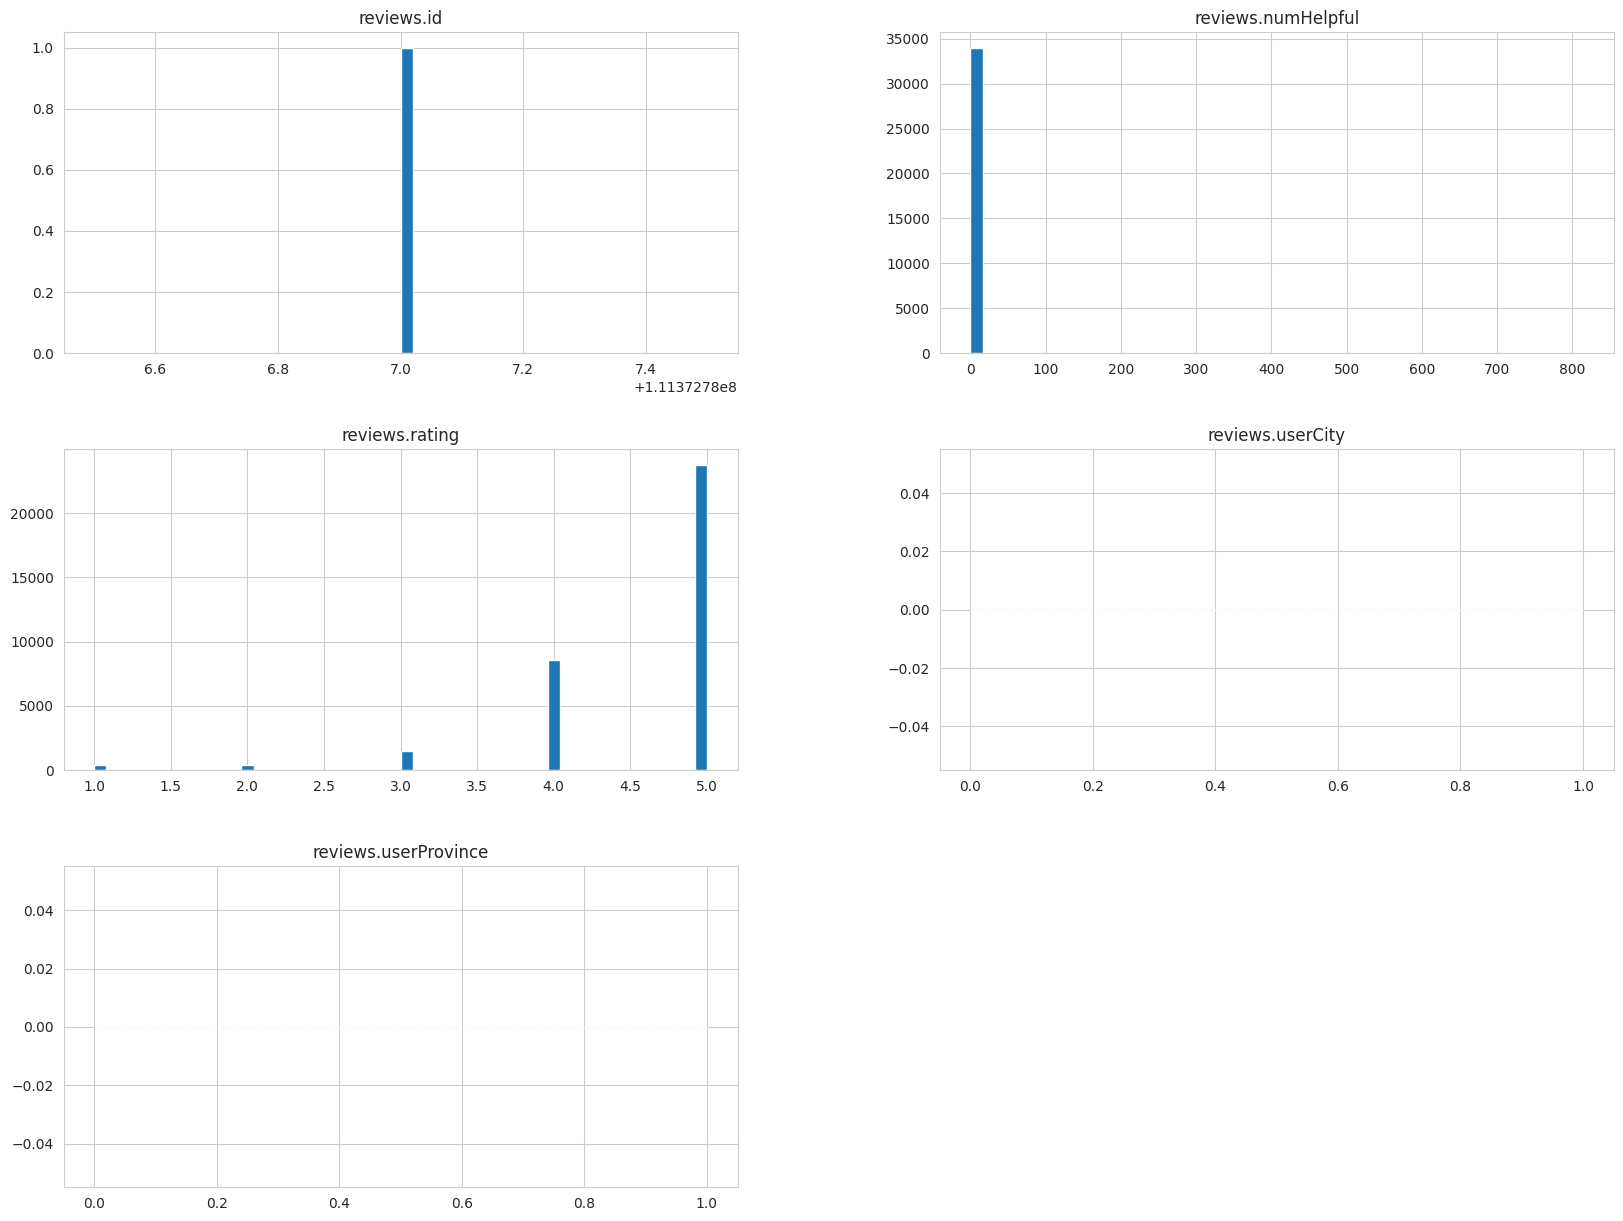

In [32]:
data.hist(bins=50, figsize=(20,15)) # builds histogram and set the number of bins and fig size (width, height)
plt.show()

Based on the distributions above:
- reviews.numHelpful: Outliers in this case are valuable, so we may want to weight reviews that had more than 50+ people who find them helpful
- reviews.rating: Majority of examples were rated highly (looking at rating distribution). There is twice amount of 5 star ratings than the others ratings combined

# 3 Split into Train/Test

- Before we explore the dataset we're going to split it into training set and test sets
- Our goal is to eventually train a sentiment analysis classifier
- Since the majority of reviews are positive (5 stars), we will need to do a stratified split on the reviews score to ensure that we don't train the classifier on imbalanced data
- To use sklearn's `Stratified ShuffleSplit` class, we're going to remove all samples that have NAN in review score, then covert all review scores to `integer` datatype

In [33]:
from sklearn.model_selection import StratifiedShuffleSplit
print("Before {}".format(len(data)))
dataAfter = data.dropna(subset=["reviews.rating"]) # removes all NAN in reviews.rating
print("After {}".format(len(dataAfter)))
dataAfter["reviews.rating"] = dataAfter["reviews.rating"].astype(int)

Before 34660
After 34627


In [34]:
split = StratifiedShuffleSplit(n_splits=5, test_size=0.2)
for train_index, test_index in split.split(dataAfter, dataAfter["reviews.rating"]): 
    strat_train = dataAfter.reindex(train_index)
    strat_test = dataAfter.reindex(test_index)

**Check to see if train/test sets were stratified proportionately in comparison to raw data.**

In [35]:
len(strat_train)

27701

In [36]:
strat_train["reviews.rating"].value_counts()/len(strat_train) # value_count() counts all the values based on column

5.0    0.685174
4.0    0.247031
3.0    0.043500
2.0    0.011696
1.0    0.011588
Name: reviews.rating, dtype: float64

In [37]:
len(strat_test)

6926

In [38]:
strat_test["reviews.rating"].value_counts()/len(strat_test)

5.0    0.689864
4.0    0.244730
3.0    0.042160
1.0    0.011406
2.0    0.011118
Name: reviews.rating, dtype: float64

# 4 Data Exploration (Training Set)

In [39]:
reviews = strat_train.copy()
reviews.head(2)

,id,name,asins,brand,categories,keys,manufacturer,reviews.date,reviews.dateAdded,reviews.dateSeen,...,reviews.doRecommend,reviews.id,reviews.numHelpful,reviews.rating,reviews.sourceURLs,reviews.text,reviews.title,reviews.userCity,reviews.userProvince,reviews.username
4349,AVphgVaX1cnluZ0-DR74,"Fire Tablet, 7 Display, Wi-Fi, 8 GB - Includes...",B018Y229OU,Amazon,"Fire Tablets,Tablets,Computers & Tablets,All T...",firetablet7displaywifi8gbincludesspecialoffers...,Amazon,2015-11-28T00:00:00.000Z,2017-05-21T04:06:08Z,"2017-04-30T00:26:00.000Z,2017-06-07T08:10:00.000Z",...,True,NaN,5.0,5.0,http://reviews.bestbuy.com/3545/5025800/review...,we bought this for my 11 year old daughter and...,great for all ages,NaN,NaN,Mark
30776,AV1YE_muvKc47QAVgpwE,NaN,B00U3FPN4U,Amazon Fire Tv,"Back To College,College Electronics,College Tv...","848719057492,amazonfiretv/51454342,amazonfiret...",Amazon,2017-01-06T00:00:00.000Z,2017-09-20T05:35:55Z,"2017-08-25T22:21:42.763Z,2017-08-19T09:26:46.1...",...,True,NaN,0.0,5.0,http://reviews.bestbuy.com/3545/4370400/review...,"I have the Roku 4, and new Apple TV, this stre...",Great streaming box,NaN,NaN,Techno


Next, we will explore the following columns:
- asins
- name
- reviews.rating
- reviews.doRecommend
- (reviews.numHelpful - not possible since numHelpful is only between 0-13 as per previous analysis in Raw Data)
- (reviews.text - not possible since text is in long words)

Also, we will explore columns to asins

## 4.1 names / ASINs

In [40]:
len(reviews["name"].unique()), len(reviews["asins"].unique())

(47, 35)

In [41]:
reviews.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27701 entries, 4349 to 29636
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    27673 non-null  object 
 1   name                  22268 non-null  object 
 2   asins                 27672 non-null  object 
 3   brand                 27673 non-null  object 
 4   categories            27673 non-null  object 
 5   keys                  27673 non-null  object 
 6   manufacturer          27673 non-null  object 
 7   reviews.date          27659 non-null  object 
 8   reviews.dateAdded     19228 non-null  object 
 9   reviews.dateSeen      27673 non-null  object 
 10  reviews.didPurchase   1 non-null      object 
 11  reviews.doRecommend   27257 non-null  object 
 12  reviews.id            1 non-null      float64
 13  reviews.numHelpful    27304 non-null  float64
 14  reviews.rating        27673 non-null  float64
 15  reviews.sourceUR

Working hypothesis: there are only 35 products based on the training data ASINs
- One for each ASIN, but more product names (47)
- ASINs are what's important here since we're concerned with products. There's a one to many relationship between ASINs and names
- A single ASIN can have many names due to different vendor listings
- There could also a lot of missing names/more unique names with slight variations in title (ie. 8gb vs 8 gb, NAN for product names)

In [42]:
reviews.groupby("asins")["name"].unique()

asins
B005PB2T0S               [Amazon Kindle Lighted Leather Cover,,,\r\nAma...
B005PB2T2Q               [Fire Kids Edition Tablet, 7 Display, Wi-Fi, 1...
B00IOY8XWQ               [Kindle Paperwhite,,,\r\nKindle Paperwhite,,,,...
B00IOYAM4I               [Brand New Amazon Kindle Fire 16gb 7 Ips Displ...
B00L9EPT8O,B01E6AO69U    [Echo (White),,,\r\nEcho (White),,,, Amazon Fi...
B00LO29KXQ               [Fire Tablet, 7 Display, Wi-Fi, 8 GB - Include...
B00LW9XOJM                                                           [nan]
B00OQVZDJM               [Amazon Kindle Paperwhite - eBook reader - 4 G...
B00QFQRELG                                                           [nan]
B00QJDU3KY               [Fire Tablet, 7 Display, Wi-Fi, 8 GB - Include...
B00QL1ZN3G                                                           [nan]
B00REQKWGA               [Brand New Amazon Kindle Fire 16gb 7 Ips Displ...
B00TSUGXKE                            [Echo (White),,,\r\nEcho (White),,,]
B00U3FPN4U         

<u>Note</u>: there are actually 34 ASINs with one of the product having 2 ASINs

In [43]:
# Lets see all the different names for this product that have 2 ASINs
different_names = reviews[reviews["asins"] == "B00L9EPT8O,B01E6AO69U"]["name"].unique()
for name in different_names:
    print(name)

Echo (White),,,
Echo (White),,,
Amazon Fire Tv,,,
Amazon Fire Tv,,,
nan
Amazon - Amazon Tap Portable Bluetooth and Wi-Fi Speaker - Black,,,
Amazon - Amazon Tap Portable Bluetooth and Wi-Fi Speaker - Black,,,
Amazon Fire Hd 10 Tablet, Wi-Fi, 16 Gb, Special Offers - Silver Aluminum,,,
Amazon Fire Hd 10 Tablet, Wi-Fi, 16 Gb, Special Offers - Silver Aluminum,,,
Amazon 9W PowerFast Official OEM USB Charger and Power Adapter for Fire Tablets and Kindle eReaders,,,
Amazon 9W PowerFast Official OEM USB Charger and Power Adapter for Fire Tablets and Kindle eReaders,,,
Amazon Kindle Fire 5ft USB to Micro-USB Cable (works with most Micro-USB Tablets),,,
Amazon Kindle Fire 5ft USB to Micro-USB Cable (works with most Micro-USB Tablets),,,
Kindle Dx Leather Cover, Black (fits 9.7 Display, Latest and 2nd Generation Kindle Dxs),,
Amazon Fire Hd 6 Standing Protective Case(4th Generation - 2014 Release), Cayenne Red,,,
Amazon Fire Hd 6 Standing Protective Case(4th Generation - 2014 Release), Cayenne Red

In [44]:
reviews[reviews["asins"] == "B00L9EPT8O,B01E6AO69U"]["name"].value_counts()

Echo (White),,,\r\nEcho (White),,,                                                                                                                                                                                  2318
Amazon Fire Tv,,,\r\nAmazon Fire Tv,,,                                                                                                                                                                              2029
Amazon - Amazon Tap Portable Bluetooth and Wi-Fi Speaker - Black,,,\r\nAmazon - Amazon Tap Portable Bluetooth and Wi-Fi Speaker - Black,,,                                                                           259
Amazon Fire Hd 10 Tablet, Wi-Fi, 16 Gb, Special Offers - Silver Aluminum,,,\r\nAmazon Fire Hd 10 Tablet, Wi-Fi, 16 Gb, Special Offers - Silver Aluminum,,,                                                           106
Amazon 9W PowerFast Official OEM USB Charger and Power Adapter for Fire Tablets and Kindle eReaders,,,\r\nAmazon 9W PowerFast Offici

**Confirmed our hypothesis that each ASIN can have multiple names. Therefore we should only really concern ourselves with which ASINs do well, not the product names.**

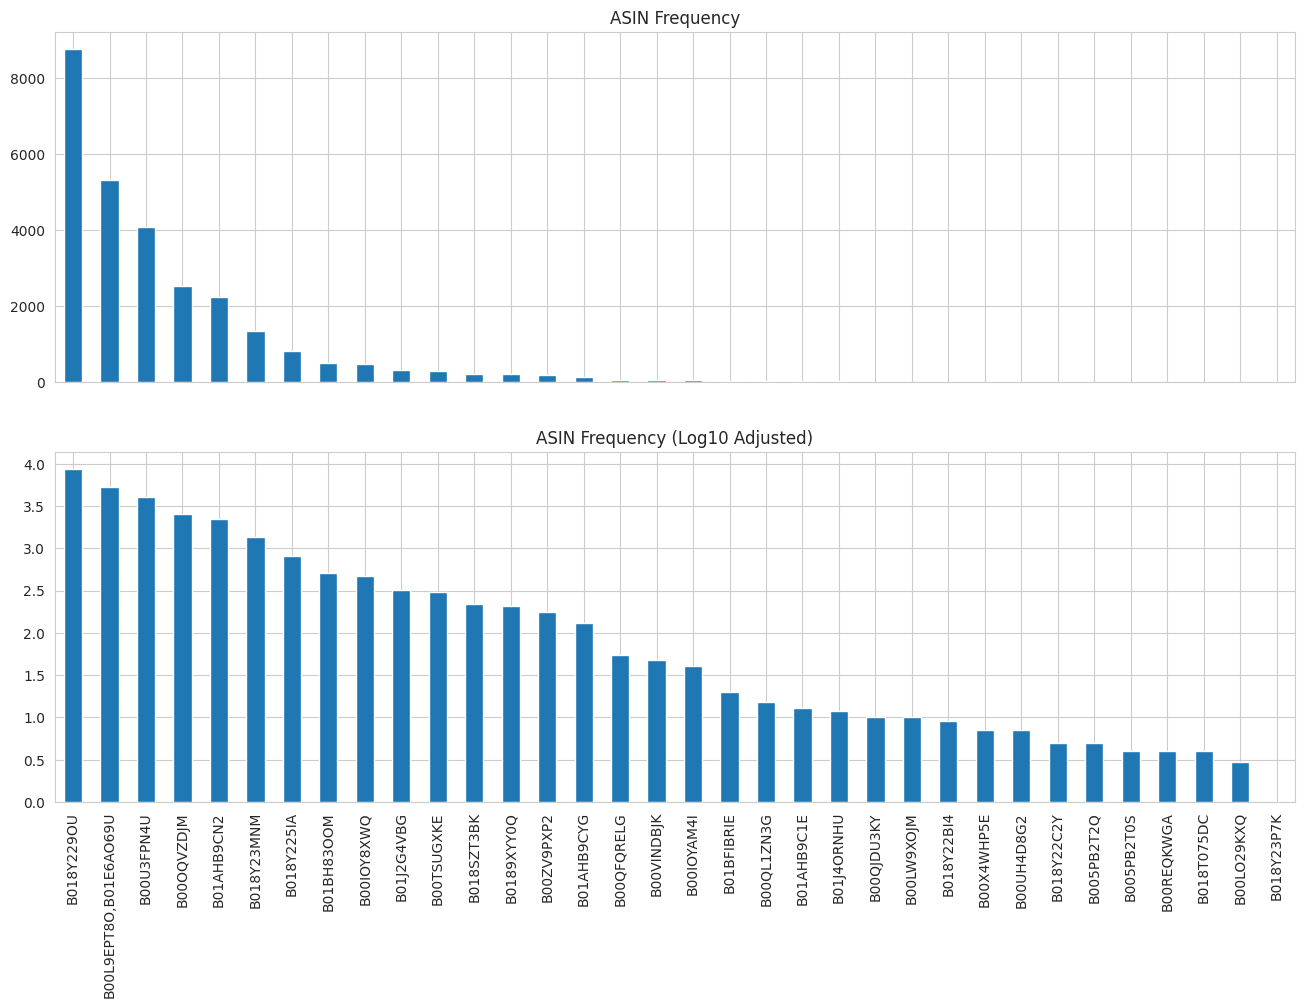

In [45]:
fig = plt.figure(figsize=(16,10))
ax1 = plt.subplot(211)
ax2 = plt.subplot(212, sharex = ax1)
reviews["asins"].value_counts().plot(kind="bar", ax=ax1, title="ASIN Frequency")
np.log10(reviews["asins"].value_counts()).plot(kind="bar", ax=ax2, title="ASIN Frequency (Log10 Adjusted)") 
plt.show()

- Based on the bar graph for ASINs, we see that certain products have significantly more reviews than other products, which may indicate a higher sale in those specific products
- We also see that the ASINs have a "right tailed" distribution which can also suggest that certain products have higher sales which can correlate to the higher ASINs frequencies in the reviews
- We also took the log of the ASINs to normalize the data, in order display an in-depth picture of each ASINs, and we see that the distribution still follows a "right tailed" distribution

**This answers the first question that certain ASINs (products) have better sales, while other ASINs have lower sale, and in turn dictates which products should be kept or dropped.**

In [46]:
# Entire training dataset average rating
reviews["reviews.rating"].mean()

4.5841072525566435

## 4.2 reviews.rating / ASINs

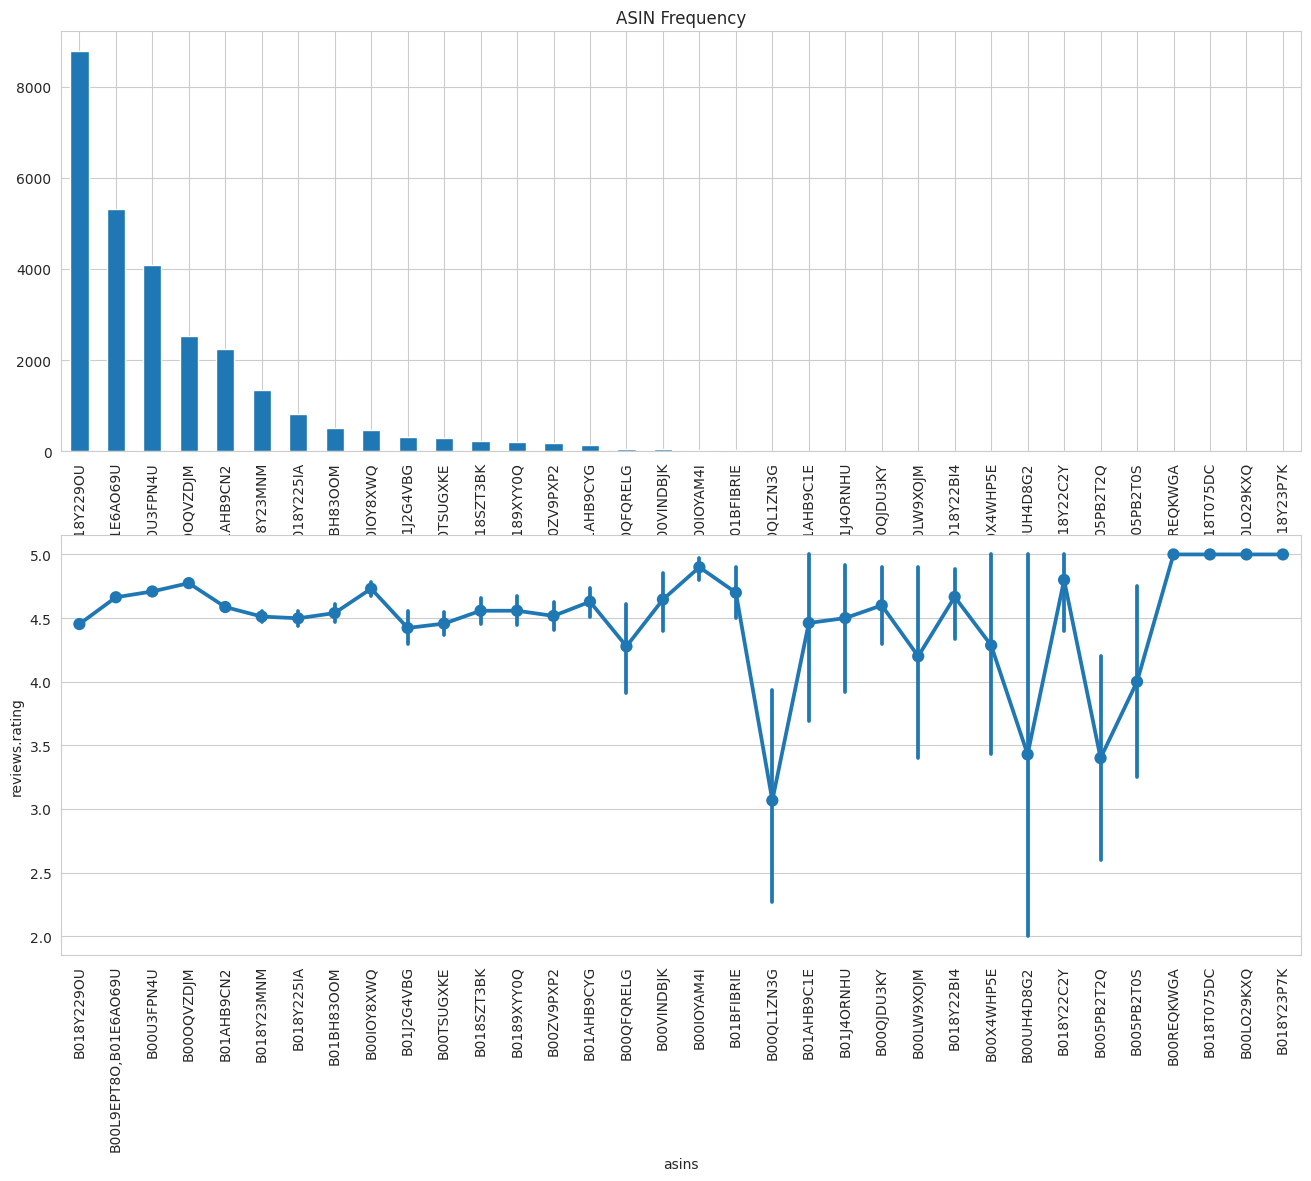

In [47]:
asins_count_ix = reviews["asins"].value_counts().index
plt.subplots(2,1,figsize=(16,12))
plt.subplot(2,1,1)
reviews["asins"].value_counts().plot(kind="bar", title="ASIN Frequency")
plt.subplot(2,1,2)
sns.pointplot(x="asins", y="reviews.rating", order=asins_count_ix, data=reviews)
plt.xticks(rotation=90)
plt.show()

- 1a) The most frequently reviewed products have their average review ratings in the 4.5 - 4.8 range, with little variance
- 1b) Although there is a slight inverse relationship between the ASINs frequency level and average review ratings for the first 4 ASINs, this relationship is not significant since the average review for the first 4 ASINs are rated between 4.5 - 4.8, which is considered good overall reviews
- 2a) For ASINs with lower frequencies as shown on the bar graph (top), we see that their corresponding average review ratings on the point-plot graph (bottom) has significantly higher variance as shown by the length of the vertical lines. As a result, we suggest that, the average review ratings for ASINs with lower frequencies are not significant for our analysis due to high variance
- 2b) On the other hand, due to their lower frequencies for ASINs with lower frequencies, we suggest that this is a result of lower quality products
- 2c) Furthermore, the last 4 ASINs have no variance due to their significantly lower frequencies, and although the review ratings are a perfect 5.0, but we should not consider the significance of these review ratings due to lower frequency as explained in 2a)

**<u>Note</u> that point-plot graph automatically takes the average of the review.rating data.**

## 4.3 reviews.doRecommend / ASINs

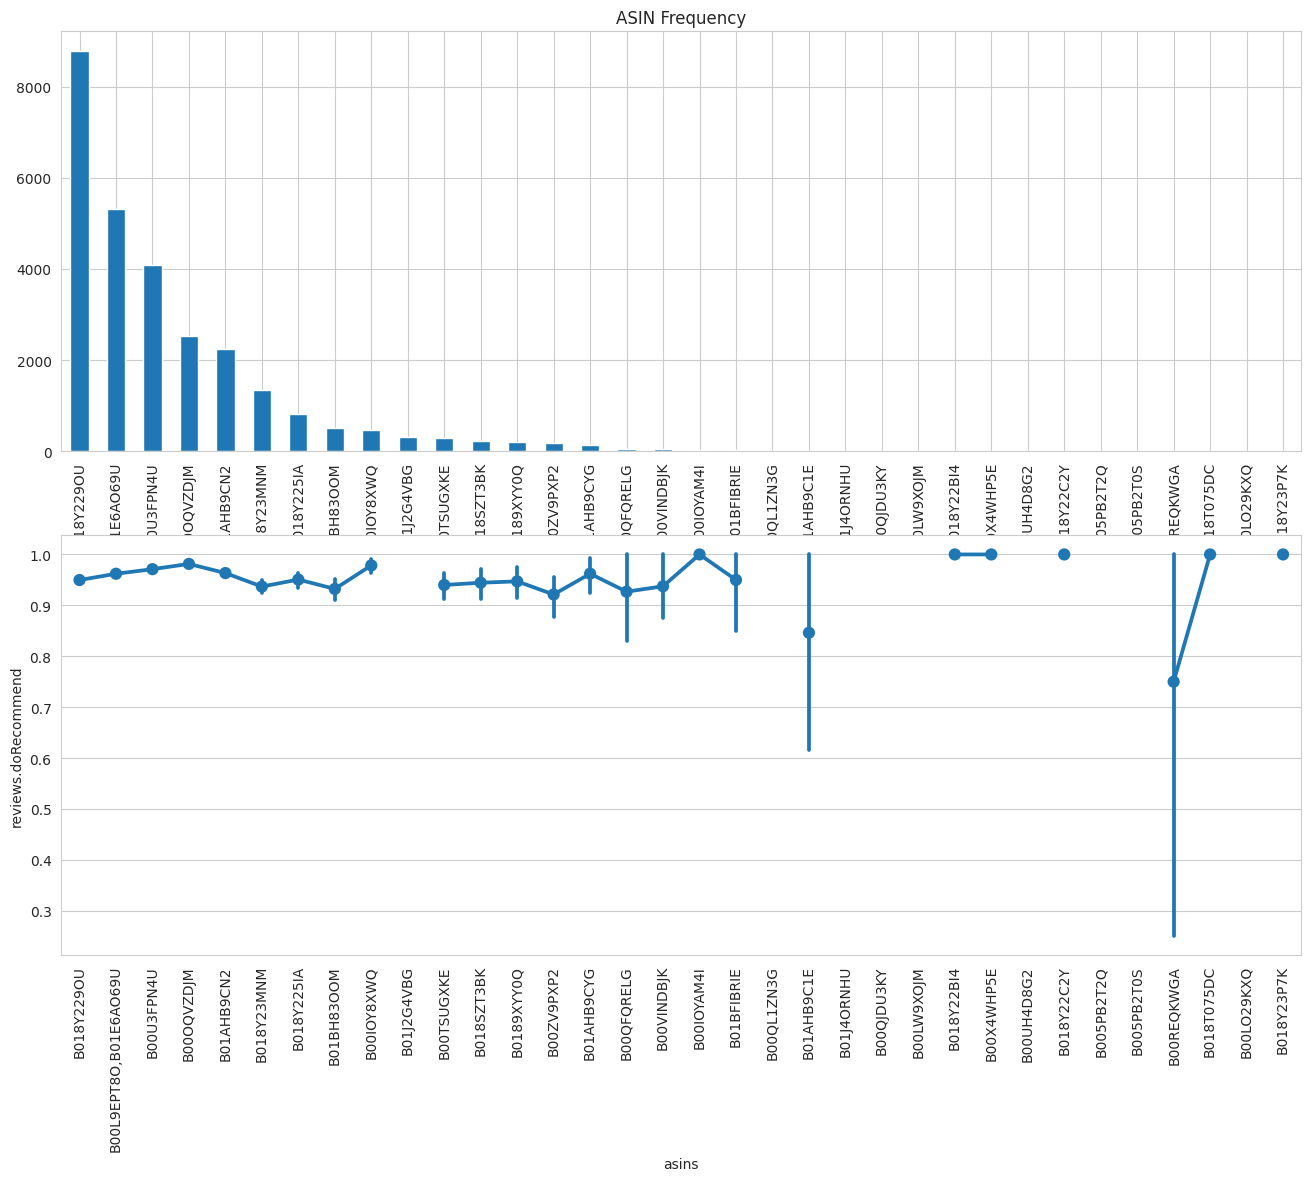

In [48]:
plt.subplots (2,1,figsize=(16,12))
plt.subplot(2,1,1)
reviews["asins"].value_counts().plot(kind="bar", title="ASIN Frequency")
plt.subplot(2,1,2)
sns.pointplot(x="asins", y="reviews.doRecommend", order=asins_count_ix, data=reviews)
plt.xticks(rotation=90)
plt.show()

- From this analysis, we can see that the first 19 ASINs show that consumers recommend the product, which is consistent with the "reviews.rating / ASINs" analysis above, where the first 19 ASINs have good ratings between 4.0 to 5.0
- The remaining ASINs have fluctuating results due to lower sample size, which should not be considered

**<u>Note</u>: reviews.text will be analyzed in Sentiment Analysis.**

# 5 Correlations

In [49]:
corr_matrix = reviews.corr()
corr_matrix
# Here we can analyze reviews.ratings with asins

,reviews.id,reviews.numHelpful,reviews.rating,reviews.userCity,reviews.userProvince
reviews.id,NaN,NaN,NaN,NaN,NaN
reviews.numHelpful,NaN,1.00000,-0.04372,NaN,NaN
reviews.rating,NaN,-0.04372,1.00000,NaN,NaN
reviews.userCity,NaN,NaN,NaN,NaN,NaN
reviews.userProvince,NaN,NaN,NaN,NaN,NaN


In [50]:
reviews.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27701 entries, 4349 to 29636
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    27673 non-null  object 
 1   name                  22268 non-null  object 
 2   asins                 27672 non-null  object 
 3   brand                 27673 non-null  object 
 4   categories            27673 non-null  object 
 5   keys                  27673 non-null  object 
 6   manufacturer          27673 non-null  object 
 7   reviews.date          27659 non-null  object 
 8   reviews.dateAdded     19228 non-null  object 
 9   reviews.dateSeen      27673 non-null  object 
 10  reviews.didPurchase   1 non-null      object 
 11  reviews.doRecommend   27257 non-null  object 
 12  reviews.id            1 non-null      float64
 13  reviews.numHelpful    27304 non-null  float64
 14  reviews.rating        27673 non-null  float64
 15  reviews.sourceUR

In [51]:
counts = reviews["asins"].value_counts().to_frame()
counts.head()

,asins
B018Y229OU,8772
"B00L9EPT8O,B01E6AO69U",5304
B00U3FPN4U,4076
B00OQVZDJM,2525
B01AHB9CN2,2241


In [52]:
avg_rating = reviews.groupby("asins")["reviews.rating"].mean().to_frame()
avg_rating.head()

,reviews.rating
asins,
B005PB2T0S,4.000000
B005PB2T2Q,3.400000
B00IOY8XWQ,4.731183
B00IOYAM4I,4.900000
"B00L9EPT8O,B01E6AO69U",4.663462


In [53]:
table = counts.join(avg_rating)
table.head(30)

,asins,reviews.rating
B018Y229OU,8772,4.453032
"B00L9EPT8O,B01E6AO69U",5304,4.663462
B00U3FPN4U,4076,4.709028
B00OQVZDJM,2525,4.774653
B01AHB9CN2,2241,4.586792
B018Y23MNM,1346,4.511887
B018Y225IA,811,4.498150
B01BH83OOM,504,4.539683
B00IOY8XWQ,465,4.731183
B01J2G4VBG,322,4.422360


,asins,reviews.rating
asins,1.000000,0.099791
reviews.rating,0.099791,1.000000


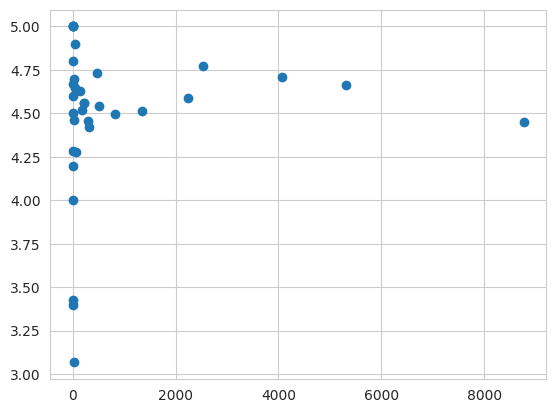

In [54]:
plt.scatter("asins", "reviews.rating", data=table)
table.corr()

From our analysis in data exploration above between ASINs and reviews.rating, we discovered that there are many ASINs with low occurrence that have high variances, as a result we concluded that theses low occurrence ASINs are not significant in our analysis given the low sample size.
<br>
<br>
Similarly in our correlation analysis between ASINs and reviews.rating, we see that there is almost no correlation which is consistent with our findings.

# 6 Sentiment Analysis

Using the features in place, we will build a classifier that can determine a review's sentiment.

## 6.1 Set Target Variable (Sentiments)

Segregate ratings from 1-5 into positive, neutral, and negative.

In [55]:
def sentiments(rating):
    if (rating == 5) or (rating == 4):
        return "Positive"
    elif rating == 3:
        return "Neutral"
    elif (rating == 2) or (rating == 1):
        return "Negative"
# Add sentiments to the data
strat_train["Sentiment"] = strat_train["reviews.rating"].apply(sentiments)
strat_test["Sentiment"] = strat_test["reviews.rating"].apply(sentiments)
strat_train["Sentiment"][:20]

4349     Positive
30776    Positive
28775     Neutral
1136     Positive
17803    Positive
7336     Positive
32638    Positive
13995    Positive
6728     Negative
22009    Positive
11047    Positive
22754    Positive
5578     Positive
11673    Positive
19168    Positive
14903    Positive
30843    Positive
5440     Positive
28940    Positive
31258    Positive
Name: Sentiment, dtype: object

In [57]:
# Prepare data
X_train = strat_train["reviews.text"]
X_train_targetSentiment = strat_train["Sentiment"]
X_test = strat_test["reviews.text"]
X_test_targetSentiment = strat_test["Sentiment"]
print(len(X_train), len(X_test))

27701 6926


27,701 training samples and 6926 testing samples.

## 6.2 Extract Features

Here we will turn content into numerical feature vectors using the **Bag of Words** strategy:
- Assign fixed integer id to each word occurrence (integer indices to word occurrence dictionary)
- X[i,j] where i is the integer indices, j is the word occurrence, and X is an array of words (our training set)
<br>
<br>

In order to implement the **Bag of Words** strategy, we will use SciKit-Learn's **CountVectorizer** to performs the following:
- Text preprocessing:
    - Tokenization (breaking sentences into words)
    - Stopwords (filtering "the", "are", etc)
- Occurrence counting (builds a dictionary of features from integer indices with word occurrences)
- Feature Vector (converts the dictionary of text documents into a feature vector)

In [58]:
# Replace "nan" with space
X_train = X_train.fillna(' ')
X_test = X_test.fillna(' ')
X_train_targetSentiment = X_train_targetSentiment.fillna(' ')
X_test_targetSentiment = X_test_targetSentiment.fillna(' ')

# Text preprocessing and occurance counting
from sklearn.feature_extraction.text import CountVectorizer 
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train) 
X_train_counts.shape

(27701, 12526)

Here we have 27,701 training samples and 12,526 distinct words in our training sample.


Also, with longer documents, we typically see higher average count values on words that carry very little meaning, this will overshadow shorter documents that have lower average counts with same frequencies, as a result, we will use **TfidfTransformer** to reduce this redundancy:
- Term Frequencies (**Tf**) divides number of occurrences for each word by total number of words
- Term Frequencies times Inverse Document Frequency (**Tfidf**) downscales the weights of each word (assigns less value to unimportant stop words ie. "the", "are", etc)

In [59]:
from sklearn.feature_extraction.text import TfidfTransformer
tfidf_transformer = TfidfTransformer(use_idf=False)
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
X_train_tfidf.shape

(27701, 12526)

## 6.3 Building a Pipeline from the Extracted Features

We will use **Multinominal Naive Bayes** as our Classifier
- Multinominal Niave Bayes is most suitable for word counts where data are typically represented as **word vector counts** (number of times outcome number X[i,j] is observed over the n trials), while also ignoring non-occurrences of a feature i
- Naive Bayes is a simplified version of Bayes Theorem, where all features are assumed conditioned independent to each other (the classifiers), P(x|y) where x is the feature and y is the classifier

In [60]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
clf_multiNB_pipe = Pipeline([("vect", CountVectorizer()), ("tfidf", TfidfTransformer()), ("clf_nominalNB", MultinomialNB())])
clf_multiNB_pipe.fit(X_train, X_train_targetSentiment)

Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('clf_nominalNB', MultinomialNB())])

## 6.4 Test Model

In [61]:
import numpy as np
predictedMultiNB = clf_multiNB_pipe.predict(X_test)
np.mean(predictedMultiNB == X_test_targetSentiment)

0.9344498989315623

Here we see that our Multinominal Naive Bayes Classifier has a 93.45% accuracy level based on the features. 
<br>
<br>
Next we will conduct the following:
- Test other models
- Fine tune the best models to avoid over-fitting

## 6.5 Testing Other Models

**Logistic Regression Classifier**

In [62]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
clf_logReg_pipe = Pipeline([("vect", CountVectorizer()), ("tfidf", TfidfTransformer()), ("clf_logReg", LogisticRegression())])
clf_logReg_pipe.fit(X_train, X_train_targetSentiment)

import numpy as np
predictedLogReg = clf_logReg_pipe.predict(X_test)
np.mean(predictedLogReg == X_test_targetSentiment)

0.9392145538550389

**Support Vector Machine Classifier**

In [63]:
from sklearn.svm import LinearSVC
clf_linearSVC_pipe = Pipeline([("vect", CountVectorizer()), ("tfidf", TfidfTransformer()), ("clf_linearSVC", LinearSVC())])
clf_linearSVC_pipe.fit(X_train, X_train_targetSentiment)

predictedLinearSVC = clf_linearSVC_pipe.predict(X_test)
np.mean(predictedLinearSVC == X_test_targetSentiment)

0.9393589373375686

**Decision Tree Classifier**

In [64]:
from sklearn.tree import DecisionTreeClassifier
clf_decisionTree_pipe = Pipeline([("vect", CountVectorizer()), ("tfidf", TfidfTransformer()), 
                                  ("clf_decisionTree", DecisionTreeClassifier())])
clf_decisionTree_pipe.fit(X_train, X_train_targetSentiment)

predictedDecisionTree = clf_decisionTree_pipe.predict(X_test)
np.mean(predictedDecisionTree == X_test_targetSentiment)

0.9016748483973434

**Random Forest Classifier**

In [65]:
from sklearn.ensemble import RandomForestClassifier
clf_randomForest_pipe = Pipeline([("vect", CountVectorizer()), ("tfidf", TfidfTransformer()), ("clf_randomForest", RandomForestClassifier())])
clf_randomForest_pipe.fit(X_train, X_train_targetSentiment)

predictedRandomForest = clf_randomForest_pipe.predict(X_test)
np.mean(predictedRandomForest == X_test_targetSentiment)

0.9350274328616807

Looks like all the models performed very well (>90%), and we will use the **Support Vector Machine Classifier** since it has the highest accuracy level at **93.94%**.
<br>
Now we will fine tune the Support Vector Machine model (Linear_SVC) to avoid any potential over-fitting.

## 6.6 Fine tuning the Support Vector Machine Classifier

- Here we will run a **Grid Search** of the best parameters on a grid of possible values, instead of tweaking the parameters of various components of the chain (ie. use_idf in tfidftransformer)
- We will also run the grid search with LinearSVC classifier pipeline, parameters and cpu core maximization
- Then we will fit the grid search to our training data set
- Next we will use our final classifier (after fine-tuning) to test some arbitrary reviews
- Finally we will test the accuracy of our final classifier (after fine-tuning)

Note that **Support Vector Machines** is very suitable for classification by measuring extreme values between classes, to differentiate the worst case scenarios so that it can classify between Positive, Neutral and Negative correctly.

In [82]:
from sklearn.model_selection import GridSearchCV
parameters = {'vect__ngram_range': [(1, 1), (1, 2)],    
             'tfidf__use_idf': (True, False), 
             } 
gs_clf_LinearSVC_pipe = GridSearchCV(clf_linearSVC_pipe, parameters, n_jobs=-1)
gs_clf_LinearSVC_pipe1 = gs_clf_LinearSVC_pipe.fit(X_train, X_train_targetSentiment)
new_text = ["The tablet is good, really liked it.",
            "The tablet is ok, but it works fine.",
            "The tablet is not good, does not work very well."] # negative

predicted_sentiments =gs_clf_LinearSVC_pipe1.predict(new_text)
print(predicted_sentiments)

['Positive' 'Neutral' 'Negative']


In [77]:
predictedGS_clf_LinearSVC_pipe = gs_clf_LinearSVC_pipe.predict(X_test)
np.mean(predictedGS_clf_LinearSVC_pipe == X_test_targetSentiment)

0.9408027721628646

**Results:**
- After testing some arbitrary reviews, it seems that our features is performing correctly with Positive, Neutral, Negative results
- We also see that after running the grid search, our Support Vector Machine Classifier has improved to **94.08%** accuracy level

## 6.7 Detailed Performance Analysis of Support Vector Machine Classifier

For detailed analysis, we will:
- Analyze the best mean score of the grid search (classifier, parameters, CPU core)
- Analyze the best estimator
- Analyze the best parameter

In [68]:
for performance_analysis in (gs_clf_LinearSVC_pipe.best_score_, 
                             gs_clf_LinearSVC_pipe.best_estimator_, 
                             gs_clf_LinearSVC_pipe.best_params_):
        print(performance_analysis)

0.9366809937342697
Pipeline(steps=[('vect', CountVectorizer(ngram_range=(1, 2))),
                ('tfidf', TfidfTransformer()), ('clf_linearSVC', LinearSVC())])
{'tfidf__use_idf': True, 'vect__ngram_range': (1, 2)}


- Here we see that the best mean score of the grid search is 93.65% which is very close to our accuracy level of 94.08%
- Our best estimator here is also displayed
- Lastly, our best parameters are true for use_idf in tfidf, and ngram_range between 1,2

In [69]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

print(classification_report(X_test_targetSentiment, predictedGS_clf_LinearSVC_pipe))
print('Accuracy: {}'. format(accuracy_score(X_test_targetSentiment, predictedGS_clf_LinearSVC_pipe)))

              precision    recall  f1-score   support

                   0.00      0.00      0.00         5
    Negative       0.67      0.25      0.36       156
     Neutral       0.47      0.11      0.18       292
    Positive       0.95      1.00      0.97      6473

    accuracy                           0.94      6926
   macro avg       0.52      0.34      0.38      6926
weighted avg       0.92      0.94      0.92      6926

Accuracy: 0.9408027721628646


Below is the summary of the classification report:
- Precision: determines how many objects selected were correct
- Recall: tells you how many of the objects that should have been selected were actually selected
- F1 score measures the weights of recall and precision (1 means precision and recall are equally important, 0 otherwise)
- Support is the number of occurrences of each class

The results in this analysis confirms our previous data exploration analysis, where the data are very skewed to the positive reviews as shown by the lower support counts in the classification report. Also, both neutral and negative reviews has large standard deviation with small frequencies, which we would not consider significant as shown by the lower precision, recall and F1 scores in the classification report.

However, despite that Neutral and Negative results are not very strong predictors in this data set, it still shows a 94.08% accuracy level in predicting the sentiment analysis, which we tested and worked very well when inputting arbitrary text (new_text). Therefore, we are comfortable here with the skewed data set. Also, as we continue to input new dataset in the future that is more balanced, this model will then re-adjust to a more balanced classifier which will increase the accuracy level.

<u>Note</u>: The first row will be ignored as we previously replaced all NAN with " ". We tried to remove this row when we first imported the raw data, but Pandas `DataFrame` did not like this row removed when we tried to drop all NAN (before stratifying and splitting the dataset). As a result, replacing the NAN with " " was the best workaround and the first row will be ignored in this analysis.

Finally, the overall result here explains that the products in this dataset are generally positively rated.

In [70]:
from sklearn import metrics
metrics.confusion_matrix(X_test_targetSentiment, predictedGS_clf_LinearSVC_pipe)

array([[   0,    0,    0,    5],
       [   0,   39,   13,  104],
       [   0,   14,   32,  246],
       [   0,    5,   23, 6445]])

<u>Note</u>: The first row and column will be ignored as we previously replaced all NAN with " ". This is the same situation explained above in the classification report.

By considering only row 2-4 and column 2-4 labeled as negative, neutral and positive, we see that positive sentiment can sometimes be confused for one another with neutral and negative ratings, with scores of 246 and 104 respectively. However, based on the overall number of significant positive sentiment at a score 6445, then confusion score of 246 and 104 for neutral and negative ratings respectively are considered insignificant.

Also, this is a result of positively skewed dataset, which is consistent with both our data exploration and sentiment analysis. Therefore, we conclude that the products in this dataset are generally positively rated, and should be kept from Amazon's product roster.

# 7 Answering the Questions

From the analysis above in the classification report, we can see that products with lower reviews are not significant enough to predict these lower rated products are inferior. On the other hand, products that are highly rated are considered superior products, which also performs well and should continue to sell at a high level.

As a result, we need to input more data in order to consider the significance of lower rated product, in order to determine which products should be dropped from Amazon's product roster.

The good news is that despite the skewed dataset, we were still able to build a robust Sentiment Analysis machine learning system to determine if the reviews are positive or negative. This is possible as the machine learning system was able to learn from all the positive, neutral and negative reviews, and fine tune the algorithm in order to avoid bias sentiments. 

In conclusion, although we need more data to balance out the lower rated products to consider their significance, however we were still able to successfully associate positive, neutral and negative sentiments for each product in Amazon's Catalog.